In [ ]:
model_name = "roberta-base" # max token = 512
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import torch
from torch.utils.data import Dataset
import os
os.environ["WANDB_DISABLED"] = "true"

# ----------------------------
# Dataclass set and tokeniztaion
# ----------------------------

class PairDataset(Dataset):
  def __init__(self, df, tokenizer, field1, field2, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.field1 = field1
        self.field2 = field2
        self.max_length = max_length

  def __len__(self):
      return len(self.df)

  def __getitem__(self, idx):
      row = self.df.iloc[idx]
      encoded = self.tokenizer(
          row[self.field1],
          row[self.field2],
          truncation=True,
          padding="max_length",
          max_length=self.max_length,
          return_tensors="pt",
      )
      return {
          "input_ids": encoded["input_ids"].squeeze(),
          "attention_mask": encoded["attention_mask"].squeeze(),
          "labels": torch.tensor(row["label"], dtype=torch.long),
      }

# ----------------------------
# metirc help function
# ----------------------------
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=-1)
  return {
      "accuracy": accuracy_score(labels, preds),
      "f1": f1_score(labels, preds),
  }


In [ ]:
# ----------------------------
# train_and_save help function
# ----------------------------
def train_and_save_roberta(train_df, val_df, field1, field2, save_name,
                           max_length=128, epochs=1, batch=16):

    model_name = "roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_dataset = PairDataset(train_df, tokenizer, field1, field2, max_length)
    val_dataset   = PairDataset(val_df, tokenizer, field1, field2, max_length)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    training_args = TrainingArguments(
        output_dir="./roberta-checkpoints",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=batch,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        bf16=True,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    save_path = f"/content/drive/MyDrive/266NoteBooks/FinalProject/Model/{save_name}"
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)

    print("Model saved to:", save_path)
    return save_path

# ----------------------------
# load_and_eval help function
# ----------------------------

def load_and_eval_roberta(model_path, test_df, field1, field2, max_length=128):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    test_dataset = PairDataset(test_df, tokenizer, field1, field2, max_length)

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    metrics = trainer.evaluate(test_dataset)
    print("Test Metrics:", metrics)
    return metrics


# ----------------------------
# Run pipeline (train-save-load-eval OR load-eval)
# ----------------------------

def run_roberta_pipeline(pair_type, field1, field2, save_name,
                         max_length=128, epochs=1, batch=16, train_first=True):

    data_root = '/content/drive/MyDrive/266NoteBooks/FinalProject/Data/'
    model_root = "/content/drive/MyDrive/266NoteBooks/FinalProject/Model"
    model_path = f"{model_root}/{save_name}"

    # Load data
    train_df = pd.read_json(f"{data_root}{pair_type}/train.jsonl", lines=True)
    val_df   = pd.read_json(f"{data_root}{pair_type}/val.jsonl", lines=True)
    test_df  = pd.read_json(f"{data_root}{pair_type}/test.jsonl", lines=True)

    print(f"\nLoaded dataset: {pair_type}")
    print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

    if train_first:
        print(f"\nTraining RoBERTa → {save_name}")
        model_path = train_and_save_roberta(
            train_df=train_df,
            val_df=val_df,
            field1=field1,
            field2=field2,
            save_name=save_name,
            max_length=max_length,
            epochs=epochs,
            batch=batch
        )
    else:
        print(f"\nLoading existing RoBERTa model: {model_path}")

    # Evaluate
    metrics = load_and_eval_roberta(
        model_path=model_path,
        test_df=test_df,
        field1=field1,
        field2=field2,
        max_length=max_length
    )

    print(f"\nFinished: {save_name}")
    return metrics


In [ ]:
run_roberta_pipeline("title-title-pair","title1", "title2", save_name="roberta-base-title-v1",
                     max_length=128, batch=32, epochs=1,train_first=True)


Loaded dataset: title-title-pair
Train: (489640, 3) Val: (58976, 3) Test: (59660, 3)

Training RoBERTa → roberta-base-title-v1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1088031608.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.097300,0.120701,0.961527,0.961111


Model saved to: /content/drive/MyDrive/266NoteBooks/FinalProject/Model/roberta-base-title-v1


/tmp/ipython-input-1088031608.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Test Metrics: {'eval_loss': 0.10917443037033081, 'eval_model_preparation_time': 0.003, 'eval_accuracy': 0.9631411330874958, 'eval_f1': 0.9627874705971943, 'eval_runtime': 139.0787, 'eval_samples_per_second': 428.966, 'eval_steps_per_second': 53.624}

Finished: roberta-base-title-v1


{'eval_loss': 0.10917443037033081,
 'eval_model_preparation_time': 0.003,
 'eval_accuracy': 0.9631411330874958,
 'eval_f1': 0.9627874705971943,
 'eval_runtime': 139.0787,
 'eval_samples_per_second': 428.966,
 'eval_steps_per_second': 53.624}

In [ ]:
run_roberta_pipeline("body-body-pair","body1", "body2",save_name="roberta-base-body-v1",
                     max_length=512, batch=16,epochs=1,train_first=True)


Loaded dataset: body-body-pair
Train: (402588, 3) Val: (48390, 3) Test: (49514, 3)

Training RoBERTa → roberta-base-body-v1


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1088031608.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.083700,0.104010,0.975532,0.975347


Model saved to: /content/drive/MyDrive/266NoteBooks/FinalProject/Model/roberta-base-body-v1


/tmp/ipython-input-1088031608.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Test Metrics: {'eval_loss': 0.10283809155225754, 'eval_model_preparation_time': 0.0031, 'eval_accuracy': 0.9752393262511613, 'eval_f1': 0.975067111364191, 'eval_runtime': 192.4851, 'eval_samples_per_second': 257.236, 'eval_steps_per_second': 32.158}

Finished: roberta-base-body-v1


{'eval_loss': 0.10283809155225754,
 'eval_model_preparation_time': 0.0031,
 'eval_accuracy': 0.9752393262511613,
 'eval_f1': 0.975067111364191,
 'eval_runtime': 192.4851,
 'eval_samples_per_second': 257.236,
 'eval_steps_per_second': 32.158}

In [ ]:
run_roberta_pipeline("post-post-pair","post1", "post2",save_name="roberta-base-post-v1",
                     max_length=512, batch=16, epochs=1, train_first=True)


Loaded dataset: post-post-pair
Train: (402276, 3) Val: (46504, 3) Test: (52104, 3)

Training RoBERTa → roberta-base-post-v1


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1088031608.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.050500,0.059914,0.987205,0.987151


Model saved to: /content/drive/MyDrive/266NoteBooks/FinalProject/Model/roberta-base-post-v1


/tmp/ipython-input-1088031608.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Test Metrics: {'eval_loss': 0.05971882864832878, 'eval_model_preparation_time': 0.0029, 'eval_accuracy': 0.9872754491017964, 'eval_f1': 0.9872315840154068, 'eval_runtime': 212.7657, 'eval_samples_per_second': 244.889, 'eval_steps_per_second': 30.611}

Finished: roberta-base-post-v1


{'eval_loss': 0.05971882864832878,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.9872754491017964,
 'eval_f1': 0.9872315840154068,
 'eval_runtime': 212.7657,
 'eval_samples_per_second': 244.889,
 'eval_steps_per_second': 30.611}

## Model Comparison Dimension
### Table 1 — Title Duplicate Detection Results

| Model           | Max Length | Accuracy (%) | F1 (%) |
|-----------------|------------|--------------|--------|
| TF-IDF + LR     | N/A        | 69.62        | 66.65 |
| BERT-base       | 64         | 95.71        | 95.67 |
| SBERT(MiniLM-L6)| 128        | 95.77        | 95.75 |
| RoBERTa-base    | 64         | 96.31        | 96.28 |
| DeBERTa-base    | 128        | 97.52        | 97.53 |
| SBERT (MPNet-base) | 128        | 97.04    | 97.05 |
| ModernBERT-base | 256        | **97.64**    | **97.64** |

### Table 2 — Body Duplicate Detection Results

| Model           | Max Length | Accuracy (%) | F1 (%) |
|-----------------|------------|--------------|--------|
| TF-IDF + LR     | N/A        | 64.26        | 61.58 |
| BERT-base       | 512        | 97.87        | 97.87 |
| SBERT(MiniLM-L6)| 256        | 97.49        | 97.49     |
| RoBERTa-base    | 512        | 97.52        | 97.51     |
| DeBERTa-base    | 256        | 98.21        | 98.21     |
| SBERT (MPNet-base) | 256        | 98.30    | 98.31 |
| ModernBERT-base | 1024       | **98.73**    | **98.73** |

### Table 3 — Post Duplicate Detection Results

| Model           | Max Length | Accuracy (%) | F1 (%) |
|-----------------|------------|--------------|--------|
| TF-IDF + LR     | N/A        | 66.41        | 64.83 |
| BERT-base       | 512        | 98.59        | 98.59 |
| SBERT(MiniLM-L6)| 256          | 98.40      | 98.40     |
| RoBERTa-base    | 512          | 98.73      | 98.72 |
| DeBERTa-base    | 256          | 99.12      | 99.12 |
| SBERT (MPNet-base) | 256        | 99.13        | 99.14     |
| ModernBERT-base | 1024       | **99.32**    | **99.32** |

-------
## Data Complexity Dimension

### Table A — TF-IDF + LR Performance Across Dataset Complexity

| Dataset | Avg Tokens | Max Length Used | Accuracy (%) | F1 (%) |
|---------|------------|------------------|--------------|--------|
| Title   | ~31        | N/A              | 69.62        | 66.65 |
| Body    | ~344       | N/A              | 64.26        | 61.58 |
| Post    | ~372       | N/A              | 66.41        | 64.83 |

### Table B — BERT-base Performance Across Dataset Complexity

| Dataset | Avg Tokens | Max Length Used | Accuracy (%) | F1 (%) |
|---------|------------|------------------|--------------|--------|
| Title   | ~31        | 64               | 95.71        | 95.67 |
| Body    | ~344       | 512              | 97.87        | 97.87 |
| Post    | ~372       | 512              | 98.59        | 98.59 |

### Table C — RoBERTa-base Performance Across Dataset Complexity

| Dataset   | Avg Tokens | Max Length Used | Accuracy (%)   | F1 (%)       |
| --------- | ---------- | --------------- | ---------- | ---------- |
| Title | ~30        | 128             | 96.31 | 96.28 |
| Body  | ~350       | 512             | 97.52 | 97.51 |
| Post  | ~300       | 512             | 98.73 | 98.72 |


### Table D — ModernBERT-base Performance Across Dataset Complexity

| Dataset | Avg Tokens | Max Length Used | Accuracy (%) | F1 (%) |
|---------|------------|------------------|--------------|--------|
| Title   | ~31        | 256              | 97.64        | 97.64 |
| Body    | ~344       | 1024             | 98.73        | 98.73 |
| Post    | ~372       | 1024             | 99.32        | 99.32 |

### Table E — DeBERTa-base Performance Across Dataset Complexity

| Dataset | Avg Tokens | Max Length Used | Accuracy (%) | F1 (%) |
| ------- | ---------- | --------------- | ------------ | ------ |
| Title   | -        | 128             | 97.52        | 97.53  |
| Body    | -        | 256             | 98.21        | 98.21  |
| Post    | -        | 256             | 99.12        | 99.12  |

### Table F1 — SBERT (all-MiniLM-L6-v2) Performance Across Dataset Complexity

| Dataset | Avg Tokens | Max Length Used | Accuracy (%) | F1 (%) |
| ------- | ---------- | --------------- | ------------ | ------ |
| Title   | -        | 128             | 95.77        | 95.75  |
| Body    | -        | 256             | 97.49        | 97.49  |
| Post    | -        | 256             | 98.40        | 98.40  |

### Table F2 — SBERT (MPNet-base-v2)  Performance Across Dataset Complexity
| Dataset | Avg Tokens | Max Length | Accuracy (%) | F1 (%)    |
| ------- | ---------- | ---------- | ------------ | --------- |
| Title   | ~31        | 128        | **97.04**    | **97.05** |
| Body    | ~344       | 256        | **98.30**    | **98.31** |
| Post    | ~372       | 256        | **99.13**    | **99.14** |


-----
## Overall Mega Table — All Models × All Datasets (Accuracy & F1)
| **Model**           | **Dataset** | **Max Length** | **Accuracy** | **F1** |
| ------------------- | ----------- | -------------- | ------------ | ------ |
| **TF-IDF + LR**     | Title       | N/A            | 69.62%       | 66.65% |
|                     | Post        | N/A            | 66.41%       | 64.83% |
|                     | Body        | N/A            | 64.26%       | 61.58% |
| **BERT-base**       | Title       | 64             | 95.71%       | 95.67% |
|                     | Post        | 512            | 98.59%       | 98.59% |
|                     | Body        | 512            | 97.87%       | 97.87% |
| **RoBERTa-base**    | Title       | 128            | 96.31%       | 96.28% |
|                     | Post        | 512            | 98.73%       | 98.72% |
|                     | Body        | 512            | 97.52%       | 97.51% |
| **ModernBERT-base** | Title       | 256            | 97.64%       | 97.64% |
|                     | Post        | 1024           | 99.32%       | 99.32% |
|                     | Body        | 1024           | 98.73%       | 98.73% |
| **DeBERTa-base**      | Title       | 128            | 97.52%       | 97.53% |
|                       | Post        | 256            | 99.12%       | 99.12% |
|                       | Body        | 256            | 98.21%       | 98.21% |
| **SBERT (MiniLM-L6)** | Title       | 128            | 95.77%       | 95.75% |
|                       | Post        | 256            | 98.40%       | 98.40% |
|                       | Body        | 256            | 97.49%       | 97.49% |
| **SBERT (MPNet-base)** | Title       | 128            | 97.04%   | 97.05% |
|                        | Post        | 256            | 99.13%   | 99.14% |
|                        | Body        | 256            | 98.30%   | 98.31% |



In [4]:
results_ordered = {
    "LR": {
        "title": 66.65,
        "body": 61.58,
        "post": 64.83
    },
    "SBERT MiniLM": {
        "title": 95.75,
        "body": 97.49,
        "post": 98.40
    },
    "SBERT MPNet": {
        "title": 97.04,
        "body": 98.21,
        "post": 98.30
    },
    "BERT": {
        "title": 95.67,
        "body": 97.87,
        "post": 98.59
    },
    "RoBERTa": {
        "title": 96.28,
        "body": 97.52,
        "post": 98.72
    },
    "DeBERTa": {
        "title": 97.53,
        "body": 98.21,
        "post": 99.12
    },
    "ModernBERT": {
        "title": 97.64,
        "body": 98.73,
        "post": 99.32
    }
}


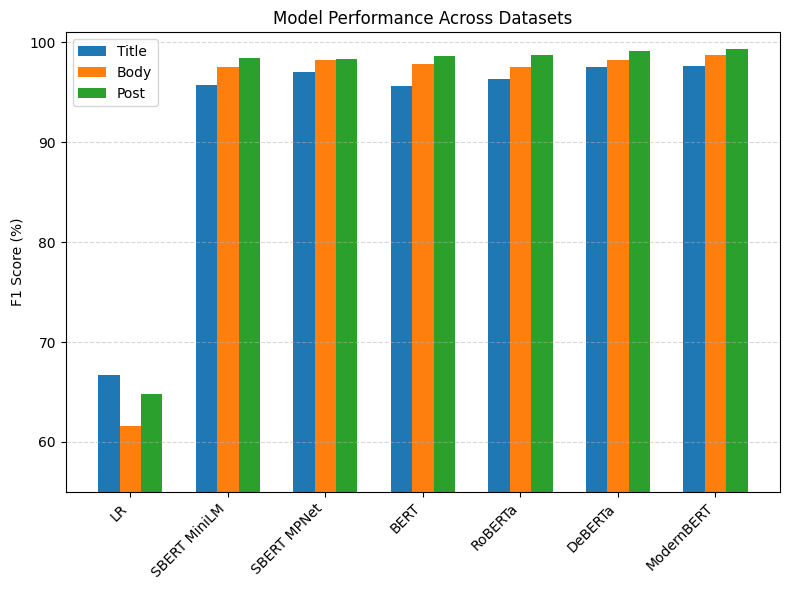

In [6]:
import numpy as np
import matplotlib.pyplot as plt

results = results_ordered

models = list(results.keys())
datasets = ["title", "body", "post"]

plt.figure(figsize=(8, 6))

bar_width = 0.22
x = np.arange(len(models))

for i, dataset in enumerate(datasets):
    f1s = [results[m][dataset] for m in models]
    plt.bar(x + i * bar_width, f1s, width=bar_width, label=dataset.capitalize())

plt.xticks(x + bar_width, models, rotation=45, ha='right')
plt.ylabel("F1 Score (%)")
plt.title("Model Performance Across Datasets")
plt.ylim(55, 101)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


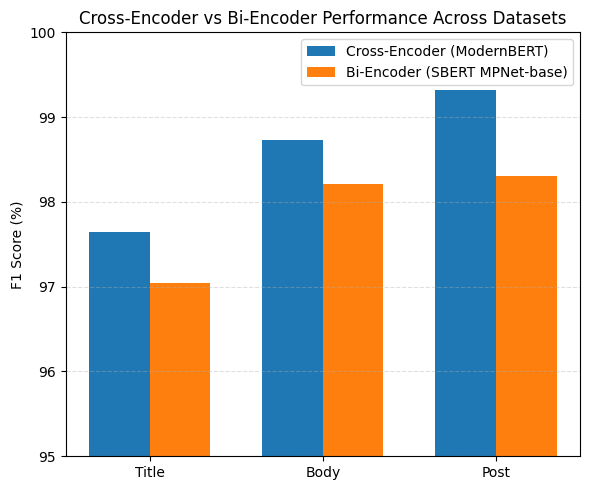

In [4]:
import matplotlib.pyplot as plt
import numpy as np

datasets = ["Title", "Body", "Post"]

# Cross-Encoder: ModernBERT (best cross-encoder)
cross_f1 = [97.64, 98.73, 99.32]

# Bi-Encoder: SBERT MPNet-base (best bi-encoder)
bi_f1 = [97.04, 98.21, 98.30]

x = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(6,5))
plt.bar(x - width/2, cross_f1, width, label="Cross-Encoder (ModernBERT)")
plt.bar(x + width/2, bi_f1, width, label="Bi-Encoder (SBERT MPNet-base)")

plt.ylabel("F1 Score (%)")
plt.title("Cross-Encoder vs Bi-Encoder Performance Across Datasets")
plt.xticks(x, datasets)
plt.ylim(95, 100)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
